In [1]:
import tensorflow as tf
import tensorflow_addons as tfa

from smot.jupyter import model_reports
from smot.problems.mnist import mnist_lib

/home/crutcher/git/smot/venv/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20210114). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


In [2]:
# Load (and cache) standard MNIST dataset.
(x_train, y_train), (x_test, y_test) = mnist_lib.load_mnist_data_28x28x1()

In [3]:
model = mnist_lib.build_ijcal2011_mnist_model(
    optimizer=tfa.optimizers.Lookahead(tf.keras.optimizers.Adam()),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
)

# Print the model summary.
model.summary()

batch_size = 128

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    validation_split=0.2,
)
datagen.fit(x_train)

training_generator = datagen.flow(
    x_train,
    y_train,
    subset="training",
    batch_size=batch_size,
)
validation_generator = datagen.flow(
    x_train,
    y_train,
    subset="validation",
    batch_size=batch_size,
)

Model: "LeNet5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 40)        20040     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 40)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 60)          60060     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 60)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 80)          12008

Epoch 1/200
375/375 [==============================] - 8s 14ms/step - loss: 1.2076 - accuracy: 0.7242 - val_loss: 0.6532 - val_accuracy: 0.9530

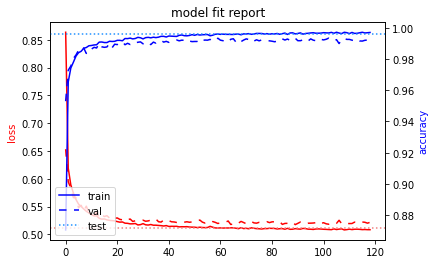

In [4]:
history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=200,
    verbose=1,
    use_multiprocessing=True,
    workers=24,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10),
    ],
)

# Evaluate the model with the test data.
test_loss, test_accuracy = model_reports.model_fit_report(
    model=model,
    history=history,
    test_data=(x_test, y_test),
)